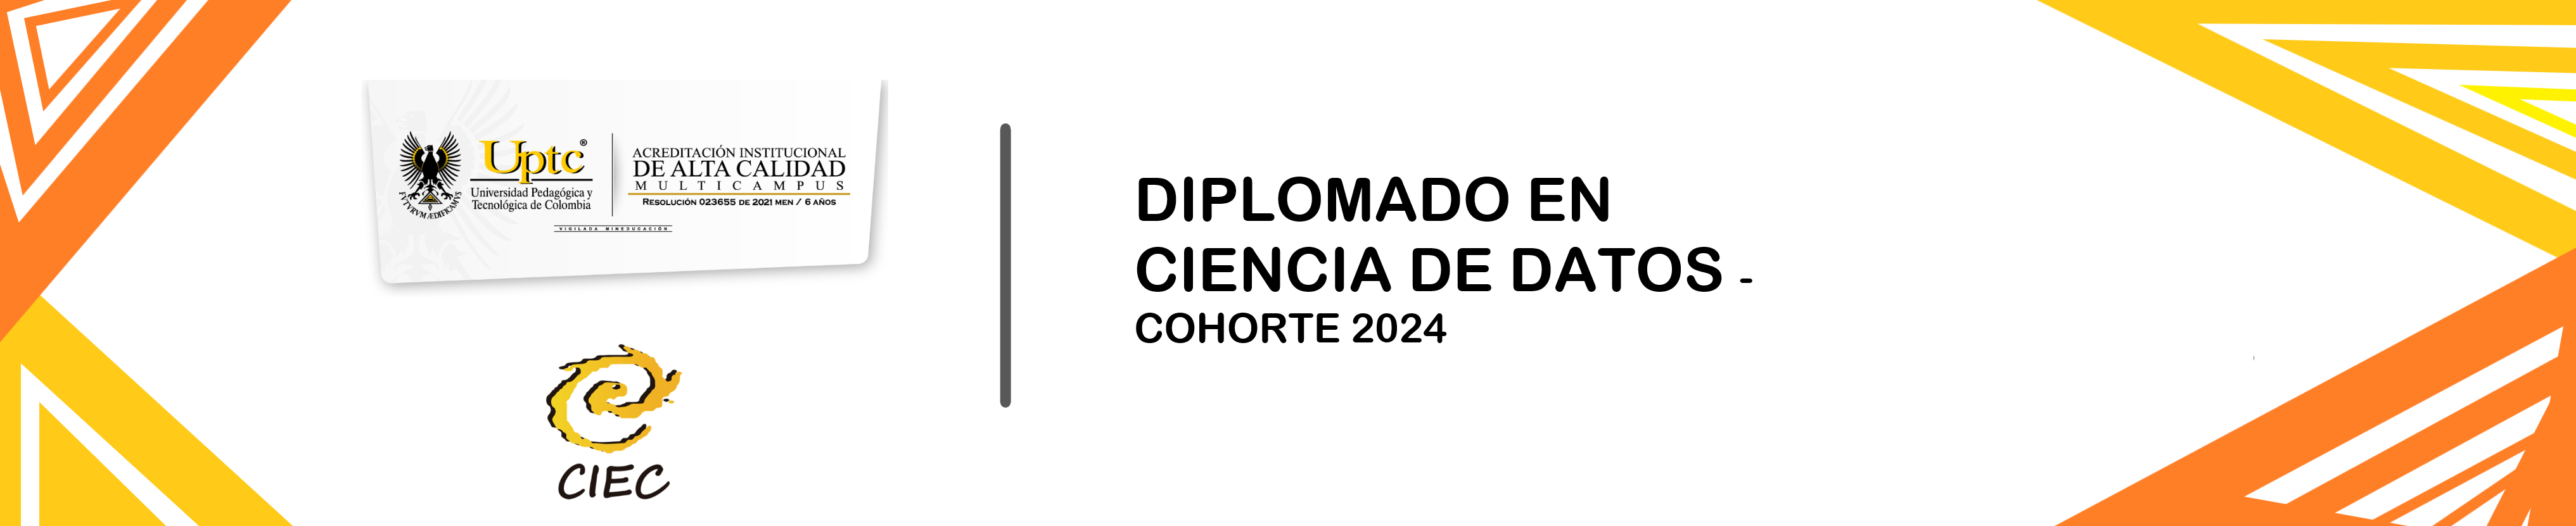

# **Proyecto 1: Análisis Exploratorio de Datos (EDA)**


Bienvenido al primer proyecto guiado del curso de "*Análisis Esploratorio de Datos (EDA)*". Durante este proyecto, harémos uso de las herramientas de análisis exploratorio de datos vistas en clase y desarrollaremos un proyecto de EDA desde cero con base a un dataset de ejemplo en el cuál responderémos diferentes preguntas a cerca de nuestro conjunto de datos con base a las cinco fases básicas del proceso de EDA:

*   Detección de valores nulos y duplicados
*   Análisis univariado de variables numéricas
*   Análisis de variables categóricas
*   Análisis bivariado y de correlación
*   Análisis multivariado

---

# **1.Importación de datos y dependencias**

### 1.1. Dependencias

---
Dependencias

---

##### 1.1.1. Librerías principales

In [12]:
# Propósito general
import warnings
warnings.simplefilter(action='ignore')
# Manejo de datos
import numpy as np
import pandas as pd
from io import StringIO
# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
# Modelamiento
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, RobustScaler, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE
from sklearn.ensemble import BaggingRegressor

##### 1.1.2. Utilidades

In [13]:
#--------------------------------------------------------------------------------
#---------------------------- Datos Excel a DatFrame ----------------------------
#--------------------------------------------------------------------------------

def excel_to_csv(path, sheet_name):
  df_excel = pd.read_excel(path, sheet_name=sheet_name)
  columnas = df_excel.columns.tolist()[0].split(',')
  data_dict = {columna: [] for columna in columnas}
  for registro in df_excel.iloc[1:].values:
    registro = registro[0]
    valores = registro.split(',')
    for i, columna in enumerate(columnas):
      data_dict[columna].append(valores[i])
  data_raw = pd.DataFrame(data_dict)
  return data_raw

#--------------------------------------------------------------------------------
#------------------------ Transformador de tipo de datos ------------------------
#--------------------------------------------------------------------------------

def trasnformar_tipo_datos(data, tipos_de_datos):
  df = data.copy()
  for columna, tipo in tipos_de_datos.items():
    df[columna] = df[columna].astype(tipo)
  return df

In [14]:
#--------------------------------------------------------------------------------
#--------------------------------- Histogram-Box --------------------------------
#--------------------------------------------------------------------------------

def histogram_box(dataframe, variable):
  df = dataframe
  fig, ax = plt.subplots(1,2,figsize=(14,5))
  # histogram_box plot
  sns.histplot(data=df, x=str(variable), kde=True, ax=ax[0])
  sns.boxplot(data=df, x=str(variable))
  # mean
  mean = df[str(variable)].mean()
  ax[0].axvline(mean, color='red')
  # stats-box
  variance = round(df[str(variable)].var(),2)
  kurtosis = round(df[str(variable)].kurt(),2)
  skewness = round(df[str(variable)].skew(),2)

  textstr = '\n'.join( (r'mean=%.2f' % (mean, ), r'Variance=%.2f' % (variance, ), r'Kurtosis=%.2f' % (kurtosis, ), r'Skewness=%.2f' % (skewness, )) )
  props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
  ax[0].text(0.05, 0.95, textstr, transform=ax[0].transAxes, fontsize=10,
             verticalalignment='top', bbox=props)
  ax[0].set_title(f'Histogram of {variable}')
  ax[0].set_xlabel(f'{variable}')
  ax[0].set_ylabel("Frecuency")
  ax[0].grid(True)
  ax[1].set_title(f'Boxplot of {variable}')
  ax[1].set_xlabel(f'{variable}')
  ax[1].set_ylabel("Frecuencias")
  ax[1].grid(True)

  plt.subplots_adjust(hspace=0.5)
  plt.show()

In [15]:
#--------------------------------------------------------------------------------
#-------------------------- Percentage of null data -----------------------------
#--------------------------------------------------------------------------------

class data_processing:
  def __init__(self):
    pass

  # Percentage of null values
  def null_classifier(self,dataframe):
    series = dataframe.isnull().sum() * 100 / dataframe.shape[0]
    nulls  = {'Variable': series.index, 'Percentage of null values': series.values}
    nulls = pd.DataFrame(nulls).sort_values(by = 'Percentage of null values', ascending = False)
    return nulls

  # Simple column selector
  def column_selector(self, dataframe, column_names):
    df = dataframe
    selected_columns = [col for col in column_names if col in df.columns]
    selected_df = df[selected_columns]
    return selected_df

  # Column selector by null percentage
  def null_df_filter(self, dataframe, threshold):
    df = dataframe
    nulls = self.null_classifier(df)
    filtered = nulls[nulls['Percentage of null values'] < threshold]['Variable']
    df_filtered = df[filtered]
    return df_filtered

### 1.3. Importación y descripción de los datos

---
Importación y descripción de los datos

---
Los sistemas de bicicletas compartidas son una innovación en alquileres de bicicletas, donde todo el proceso es automático. Actualmente, hay más de 500 programas de bicicletas compartidas en el mundo, con más de 500 mil bicicletas. Estos sistemas son importantes para el tráfico, el medio ambiente y la salud. Además, los datos generados por estos sistemas son útiles para la investigación, ya que registran la duración del viaje y las posiciones de inicio y fin, convirtiéndolos en una red de sensores virtual para detectar la movilidad en la ciudad y eventos importantes.

El diccionario de los datos es el siguiente:

|Variable|Descripción|Tipología|
|---|---|---|
|season| Estación del año (Winter, Spring, Summer, Fall)|categórica|
|weekday|Día de la semana (de 1 a 7)|numérico|
|weathersit|Clima (Clear, Mist, Light Rain, Heavy Rain)|categórica|
|temp|Temperatura|numérico|
|atemp|Sensación de temperatura|numérico|
|hum|Humedad|numérico|
|windspeed|Velocidad del viento|numérico|
|cnt|Cantidad de bicicletas rentadas|numérico|
|time_of_day|Parte del día (Morning, Evening, Night)|categórica|


In [16]:
# Importación de los datos
path = 'https://raw.githubusercontent.com/AsorKy/Datasets/main/rental_bike.csv'
df_raw = pd.read_csv(path)
print('Dimensiones de los datos=', df_raw.shape)

Dimensiones de los datos= (17379, 9)


In [17]:
# Importación y formato de los datos
df_raw.head()

season  weekday weathersit  temp   atemp   hum  windspeed  cnt time_of_day
0  Winter        6      Clear  3.28  3.0014  0.81        0.0   16       Night
1  Winter        6      Clear  2.34  1.9982  0.80        0.0   40       Night
2  Winter        6      Clear  2.34  1.9982  0.80        0.0   32       Night
3  Winter        6      Clear  3.28  3.0014  0.75        0.0   13       Night
4  Winter        6      Clear  3.28  3.0014  0.75        0.0    1       Night

Descripción de las variables del dataset.

In [18]:
# Tipos de variables en el dataset
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   season       17379 non-null  object 
 1   weekday      17379 non-null  int64  
 2   weathersit   17379 non-null  object 
 3   temp         17379 non-null  float64
 4   atemp        17379 non-null  float64
 5   hum          17379 non-null  float64
 6   windspeed    17379 non-null  float64
 7   cnt          17379 non-null  int64  
 8   time_of_day  17379 non-null  object 
dtypes: float64(4), int64(2), object(3)
memory usage: 1.2+ MB


Como vemos, todos los datos están en formato string, así pues, tenemos que transformar el tipo de datos para cada columna. Para ello, empleamos la función transformar_tipo_datos presente en la sección de utilidades 1.1.2. del presente notebook.

In [19]:
# Reasignación del tipo de dato para el dataset
tipos = {
    'season':str,
    'weekday': int,
    'weathersit': str,
    'temp': float,
    'atemp':float,
    'hum':float,
    'windspeed':float,
    'cnt': int,
    'time_of_day':str
}

df = trasnformar_tipo_datos(df_raw, tipos)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   season       17379 non-null  object 
 1   weekday      17379 non-null  int64  
 2   weathersit   17379 non-null  object 
 3   temp         17379 non-null  float64
 4   atemp        17379 non-null  float64
 5   hum          17379 non-null  float64
 6   windspeed    17379 non-null  float64
 7   cnt          17379 non-null  int64  
 8   time_of_day  17379 non-null  object 
dtypes: float64(4), int64(2), object(3)
memory usage: 1.2+ MB


# **2.Análisis Exploratorio de Datos  (EDA)**

---
Análisis Exploratorio de los Datos

---

### 2.1. Detección de valores nulos y duplicados

---
Detección de valores nulos y duplicados

---


Una vez los datos han quedado en el formato estructurado adecuado, procedemos a explorar los datos mediante visualizaciones y estadísticos principales. Para empezar, observemos la estadística descriptiva básica de nuestros datos numéricos y categóricos.

In [20]:
# Descripción estadística inicial de los datos numéricos
df.describe()

weekday          temp         atemp           hum     windspeed  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       3.003683     15.358397     15.401157      0.627229     12.736540   
std        2.005771      9.050138     11.342114      0.192930      8.196795   
min        0.000000     -7.060000    -16.000000      0.000000      0.000000   
25%        1.000000      7.980000      5.997800      0.480000      7.001500   
50%        3.000000     15.500000     15.996800      0.630000     12.998000   
75%        5.000000     23.020000     24.999200      0.780000     16.997900   
max        6.000000     39.000000     50.000000      1.000000     56.996900   

                cnt  
count  17379.000000  
mean     189.463088  
std      181.387599  
min        1.000000  
25%       40.000000  
50%      142.000000  
75%      281.000000  
max      977.000000

De los estadísticos principales podemos observar:
* En promedio, se alquila una cantidad de 189 bicicletas en el periodo de tiempo sobre el cuál los datos fueron recogidos.
* En promedio, los alquileres se realizan el cuarto día de la semana (jueves).
* El 25% de los alquileres suceden el segundo dia de la semana (martes), el 50% en el cuarto (jueves), el 75% en el sexto (sabado).
* El 25% del total de alquileres corresponde a 40, el 50% de los alquileres corresponde a 142 mientras que el 75% del total de los alquileres corresponde a 281.


Notamos por otra parte que los valores de la variable `weekday` van desde 0 a 6, información que no es consistente con el diccionario de los datos en el cual se estipula que los días van desde 1 a 7. Para mantener la congruencia entre éstos dos objetos, datos y diccionario, realizamos una transformación numérica sobre los datos de la siguiente manera.

In [21]:
# Transformación de la variable weekday
df['weekday'] = df['weekday'] + 1
df['weekday'].unique()

array([7, 1, 2, 3, 4, 5, 6])

Note entonces, ya que en el diccionario de los datos no se especifica la convención correcta entre el indice y el día de la semana, procedemos a usar la siguiente convención: `domingo:7` , `lunes:1`, `martes:2`, `miercoles:3`, `jueves:4`, `viernes:5`, `sábado:6`.

In [22]:
# Descripción estadística inicial de datos categóricos
df.describe(include='object')

season weathersit time_of_day
count    17379      17379       17379
unique       4          4           3
top     Summer      Clear       Night
freq      4496      11413        6471

Según la frecuencia de las variables categóricas, se observa que:
* El verano (summer) es la temporada anual en donde más se rentan bicicletas.
* El tipo de clima preferido por las personas para tomar paseos en bicicleta es 'Clear'.
* El horario del día donde las personas toman más paseos en bicicleta es la noche.

No obstante, ¿estas observaciones iniciales son acertadas?. Para contestar ésta pregunta, tenemos que determinar si dentro del dataset exísten valores nulos por columna para descartar la posibilidad de que nuestras observaciones estén sesgadas debido a la presencia de valores nulos.

In [23]:
# Número de valores nulos por columna
df.isnull().sum()

season         0
weekday        0
weathersit     0
temp           0
atemp          0
hum            0
windspeed      0
cnt            0
time_of_day    0
dtype: int64

Ahora, procedemos a responder la pregunta ¿exíste un número importante de duplicados?

In [24]:
# Numero de duplicados
n_duplicados = df.duplicated().sum()
porcentaje_duplicados = (n_duplicados / df.shape[0]) *100
print('El número de duplicados es = ', n_duplicados)
print('Porcentaje de duplicados es =', porcentaje_duplicados)

El número de duplicados es =  42
Porcentaje de duplicados es = 0.2416709822199206


Ya que el número de duplicados solo corresponde al 0.241% de los datos, las distribuciones no se deben ver fuertemente afectadas por su presencia, por ende, continuaremos el análisis exploratorio de los datos eliminando dichos suplicados sin temor a causar estragos en las distribuciones de los datos.

In [25]:
# Eliminación de duplicados
df.drop_duplicates(inplace=True)
n_duplicados = df.duplicated().sum()
porcentaje_duplicados = (n_duplicados / df.shape[0]) *100
print('El número de duplicados es = ', n_duplicados)
print('Porcentaje de duplicados es =', porcentaje_duplicados)

El número de duplicados es =  0
Porcentaje de duplicados es = 0.0


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17337 entries, 0 to 17378
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   season       17337 non-null  object 
 1   weekday      17337 non-null  int64  
 2   weathersit   17337 non-null  object 
 3   temp         17337 non-null  float64
 4   atemp        17337 non-null  float64
 5   hum          17337 non-null  float64
 6   windspeed    17337 non-null  float64
 7   cnt          17337 non-null  int64  
 8   time_of_day  17337 non-null  object 
dtypes: float64(4), int64(2), object(3)
memory usage: 1.3+ MB


### 2.2. Análisis univariado de variables numéricas

---
Análisis de Variables numéricas

---

Ya que no exísten valores nulos en nuestras variables, procedemos con el análisis univariado de nuestro dataset. Para empezar, observemos las distribuciones de las variables numéricas contínuas y para la variable `'cnt'` e intentemos detectar posibles valores atípicos o outliers. Para ésto, emplearemos una visualización de histograma y boxplot mediante la función `histogram_box`, presente en la sección de utilidades 1.1.2. del presente notebook.

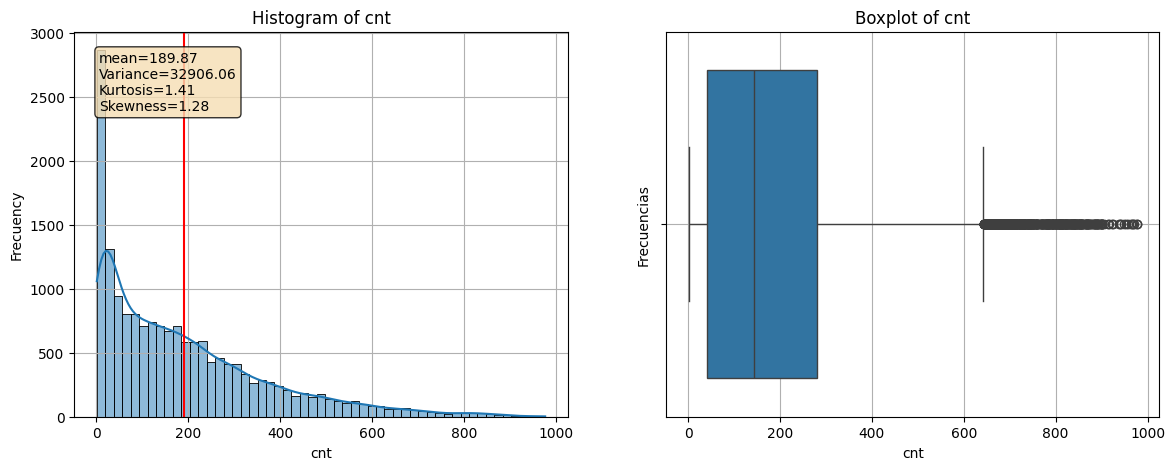

In [27]:
# Distribución (histograma) de la variable cantidad de alquileres
histogram_box(df, 'cnt')

A partir de la visualizacion anterior, podemos observar lo siguiente:
* El número de alquileres de bicicletas presenta una distribución de sus datos casi monotónicamente decreciente con respecto al número de alquileres, lo cual quiere decir que exíste una gran cantidad de personas que realiza pocos alquileres de biscicletas y una pequeña cantidad de personas que realiza una alta cantidad de alquileres. Por ende, la distribución de los datos posee una alta varianza y un sesgo (skewness) positivo. Lo que implica una distribución asimétrica.

* La gran mayoria de las personas realiza un número de alquileres entre 40 y 281. No obstante, exísten unos valores atípicos que corresponden a un selecto número de personas que realiza más de 650 alquileres.

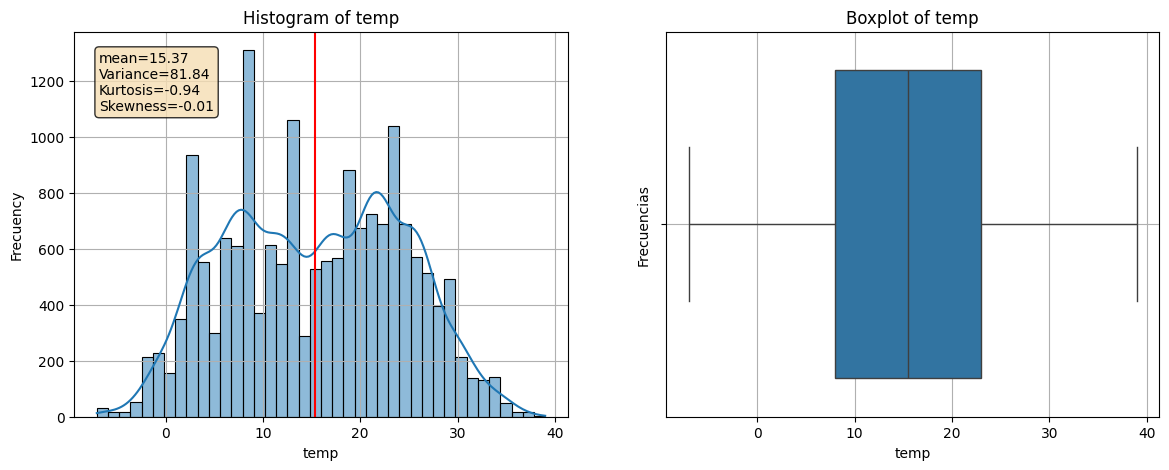

In [28]:
# Distribución (histograma) de la variable temperatura
histogram_box(df, 'temp')

A partir de la visualizacion anterior, podemos observar lo siguiente:
* La distribución del alguiler de bicicletas con respecto a la temperatura tiende a ser bimodal. Esto quiere decir que las personas prefieren realizr alquileres de bicicletas especialmente en dos valores de temperatura.

* Las personas prefieren alquilar bicicletas en promedio, cuando hace una temperatura de 15.36 grados.

* La distribución del alquiler de bicicletas con respecto a la temperatura es prácticamente simétrica lo que se traduce en un skewness cercano a cero. No se puede decir que la distribución tenga una fuerte presencia de "colas" y la mayoría de los datos se encuentra concentrados en un amplio rango ya que su kurtosis es menor a 3, por ende, es una distribuciínplaticúrtica.

* Con respecto a la temperatura, no exísten valores atípicos, por ende, los datos se encuentran altamente concentrados entre 7.9 y 23 grados.

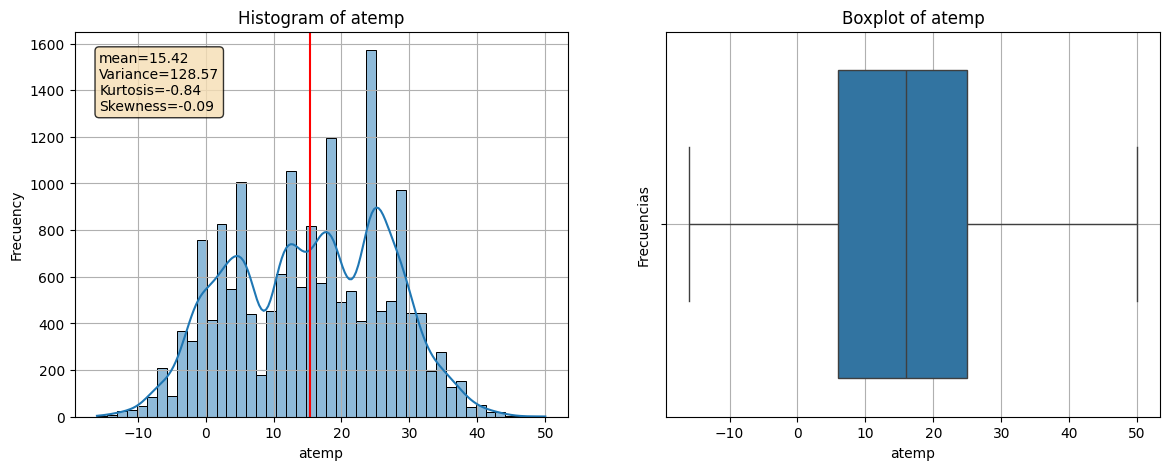

In [29]:
# Distribución (histograma) de la variable sensación de la temperatura
histogram_box(df, 'atemp')

A partir de la visualizacion anterior, podemos observar lo siguiente:
* La distribución del número de alquileres con respecto a la sensacion de la temperatura es demasiado similar a la de la temperatura, a diferencia de que en éste caso la variable tiende a tener más modas.

* En promedio, las presonas prefieren alquilar bicicletas cuando exíste una sensación térmica cercana a 15.40 grados.

* La distribución es prácticamente simétrica, sin presencia fuerte de colas y sin presencia de valores atípicos.

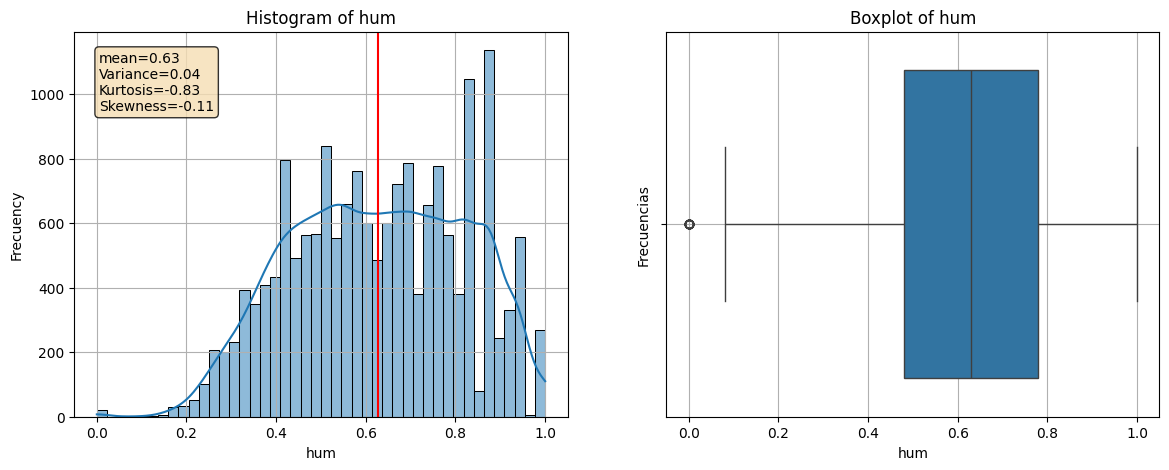

In [30]:
# Distribución (histograma) de la variable humedad
histogram_box(df, 'hum')

A partir de la visualizacion anterior, podemos observar lo siguiente:
* El alquiler de bicicletas ocurre en promedio para humedades moderadas de 0.6.
* La distribución de los alquileres en función de la humedad posee sesgo hacia la izquierda presentando sesgo negativo. Específicamente, la mayoría de los alquileres ocurre en un ampluio rango al rededor del valor de humedad 0.6  que va aproximadamente desde 0.4 hasta 0.9.
* Exíste un alto número de alguileres entre el valor de humedad 0.8 y 0.9.
* Corresponde a una distribución platicúrtica.
* Exíste un pequeño número de valores atípicos los cuales corresponden a alquileres hechos a muy bajas humedades.

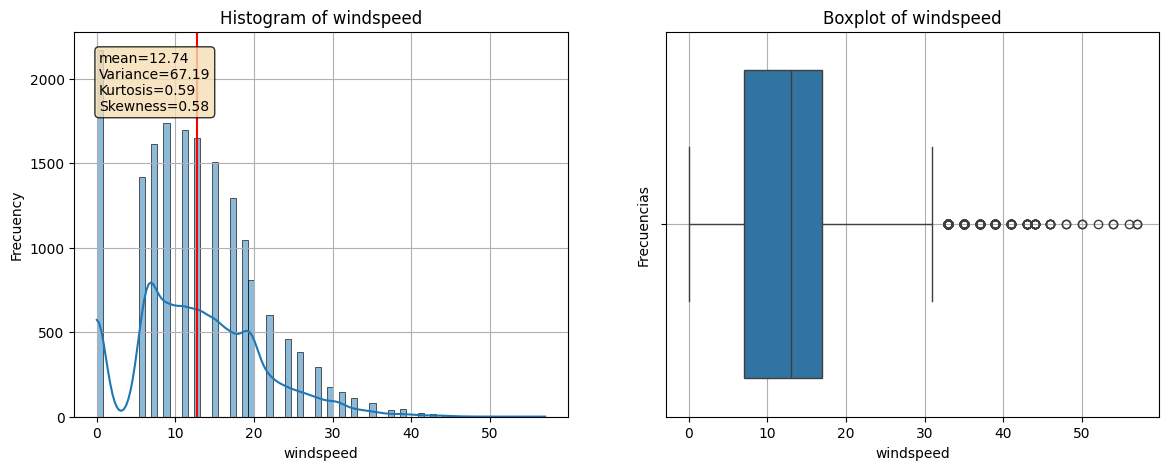

In [31]:
# Distribución (histograma) de la variable velocidad del viento
histogram_box(df, 'windspeed')

A partir de la visualizacion anterior, podemos observar lo siguiente:
* La distribución del número de alquileres en función de la velocidad del viento es ligeramente asimétrica hacia la derecha, presentando sesgo positivo.

* En promedio, los alquileres de bicicletas ocurren cuando exíste una velocidad del viento de 12.74.

* Existe una presencia de valores atípicos los cuales corresponden a alquileres hechos a altas velocidades del viento.

### 2.3. Análisis de variables categóricas

---
Análisis de variables categóricas

---

Una vez analizadas las variables numéricas no ordinales y contínuas, procedamos a analizar que ocurre con las variables categóricas y ordinales.

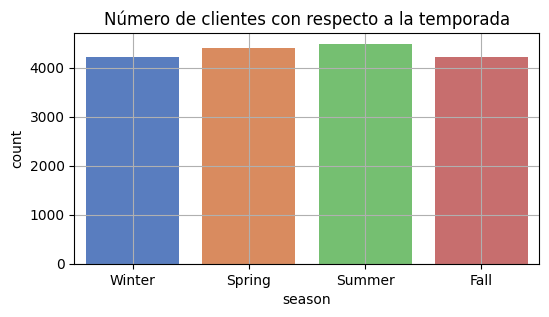

In [32]:
# Conteo de alquileres según la temporada
plt.figure(figsize=(6,3))
sns.countplot(data=df,x='season', palette = 'muted')
plt.title('Número de clientes con respecto a la temporada')
plt.grid()
plt.show()

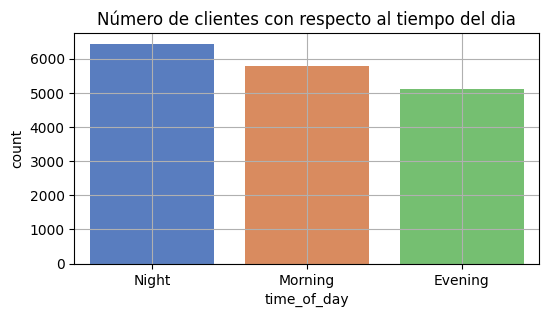

In [33]:
# Conteo de alquileres según el tiempo del día
plt.figure(figsize=(6,3))
sns.countplot(data=df,x='time_of_day',palette = 'muted')
plt.grid(True)
plt.title('Número de clientes con respecto al tiempo del dia')
plt.show()

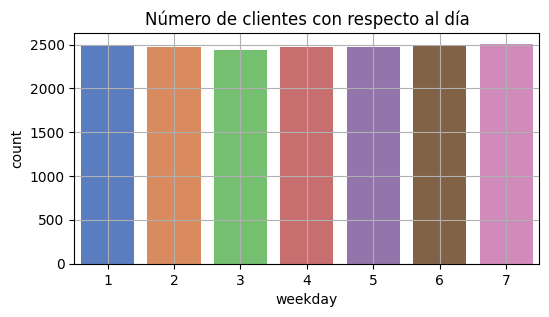

In [34]:
# Conteo de alquileres según el tiempo del día
plt.figure(figsize=(6,3))
sns.countplot(data=df,x='weekday',palette = 'muted')
plt.title('Número de clientes con respecto al día')
plt.grid(True)
plt.show()

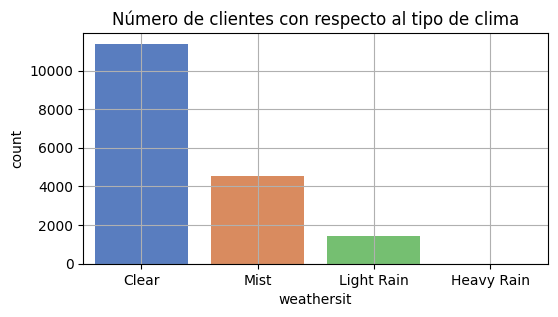

In [35]:
# Conteo de alquileres según el tipo de clima
plt.figure(figsize=(6,3))
sns.countplot(data=df,x='weathersit',palette = 'muted')
plt.title('Número de clientes con respecto al tipo de clima')
plt.grid(True)
plt.show()

Con respecto a los plots de conteo anteriores, con respecto al número de regístros de alquiler podémos concluir lo siguiente:
* La mayoría de regístros ocurren en verano.

* El tipo de clima es muy relevante, la mayoría de alquileres ocurre en clima despejado.

* No exíste una pronunciada jerarquía entre los días de la semana, no obstante, con respecto al conteo de alquileres, la mayoría de éstos ocurre en el día 7 y 1.

* La mayoría de regístros reportados según el periodo del día ocurren en la noche.

A pesar de que el número de regístros ocurridos de acuerdo a una categoría nos da indicios a cerca del comportamiento de la renta de bicicletas con respecto a cierta variable, no nos da ninguna información a cerca de **cómo se comporta el número de alquileres efectuado por una persona en función de la categoría**.

Para obtener información en éste aspecto, procedemos a realizar comparaciones entre el número de alquileres efectuados por una persona (no el número de regístros) y variables como el día de la semana, el tiempo del día, el tipo de clima y la temporada.

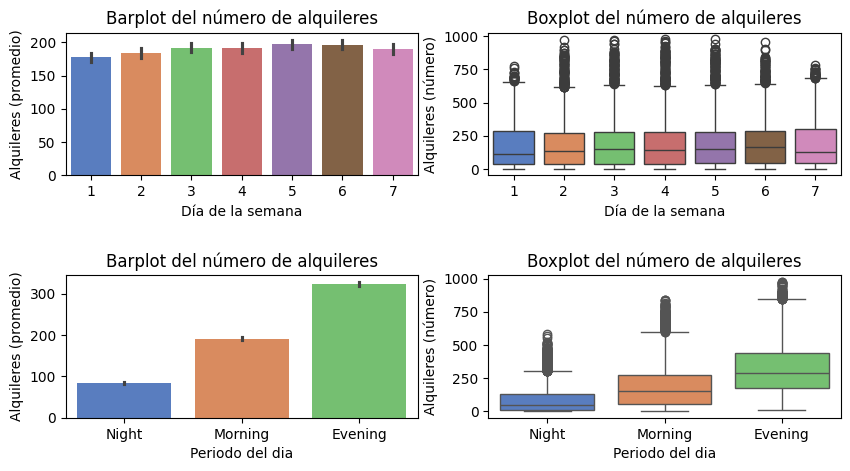

In [36]:
# Comparación entre el número de alquileres, día de la semana y el periodo del día
fig, ax = plt.subplots(2,2,figsize=(10,5))
sns.barplot(data=df, x="weekday", y="cnt", ax=ax[0,0],palette = 'muted')
sns.boxplot(data=df, x="weekday", y="cnt", ax=ax[0,1],palette = 'muted')
sns.barplot(data=df, x='time_of_day', y="cnt", ax=ax[1,0],palette = 'muted')
sns.boxplot(data=df, x='time_of_day', y="cnt", ax=ax[1,1],palette = 'muted')

ax[0,0].set_title("Barplot del número de alquileres")
ax[0,0].set_xlabel("Día de la semana")
ax[0,0].set_ylabel("Alquileres (promedio)")
ax[0,1].set_title("Boxplot del número de alquileres")
ax[0,1].set_xlabel("Día de la semana")
ax[0,1].set_ylabel("Alquileres (número)")
ax[1,0].set_title("Barplot del número de alquileres")
ax[1,0].set_xlabel("Periodo del dia")
ax[1,0].set_ylabel("Alquileres (promedio)")
ax[1,1].set_title("Boxplot del número de alquileres")
ax[1,1].set_xlabel("Periodo del dia")
ax[1,1].set_ylabel("Alquileres (número)")

plt.subplots_adjust(hspace=0.7)
plt.show()

A partir de la comparación entre el número de alquileres y variables tales como el día de la semana y periodo del día podemos observar que:

* No exíste una pronunciada jerarquía entre los días de la semana con respecto al número de alquileres por persona. No obstante, es el día 5 y 6 aquellos en donde más alquileres ocurren.

* Durante todos los días de la semana, exíste un alto número de personas que han realizado un alto número de alquileres. Es decir, el día de la semana no parece influir en la presencia de outliers (personas que rentan bicicletas con alta frecuencia).

* El periodo del día donde más personas con alta frecuencia de alquiler de bicicletas ocurren es en la tarde, luego en la mañana y por último, la noche. Es decir, a pesar de que según el periodo del día, la mayoría de regístros ocurren en la noche, las personas que alquilan bicicletas en la noche suelen alquilar bicicletas muy poco frecuente, mientras que las personas que alquílan bicicletas en la tarde, suelen ser personas que frecuentemente alquilan bicicletas.

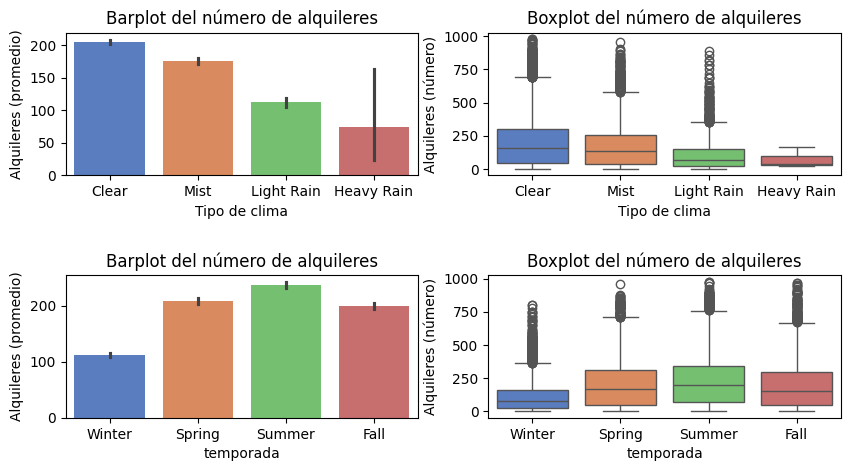

In [37]:
# Comparación entre el número de alquileres, día de la semana y la temporada
fig, ax = plt.subplots(2,2,figsize=(10,5))
sns.barplot(data=df, x='weathersit', y="cnt", ax=ax[0,0],palette = 'muted')
sns.boxplot(data=df, x='weathersit', y="cnt", ax=ax[0,1],palette = 'muted')
sns.barplot(data=df, x='season', y="cnt", ax=ax[1,0],palette = 'muted')
sns.boxplot(data=df, x="season", y="cnt", ax=ax[1,1],palette = 'muted')

ax[0,0].set_title("Barplot del número de alquileres")
ax[0,0].set_xlabel("Tipo de clima")
ax[0,0].set_ylabel("Alquileres (promedio)")
ax[0,1].set_title("Boxplot del número de alquileres")
ax[0,1].set_xlabel("Tipo de clima")
ax[0,1].set_ylabel("Alquileres (número)")
ax[1,0].set_title("Barplot del número de alquileres")
ax[1,0].set_xlabel("temporada")
ax[1,0].set_ylabel("Alquileres (promedio)")
ax[1,1].set_title("Boxplot del número de alquileres")
ax[1,1].set_xlabel("temporada")
ax[1,1].set_ylabel("Alquileres (número)")

plt.subplots_adjust(hspace=0.7)
plt.show()

A partir de la comparación entre el número de alquileres y variables tales como el tipo de clima y la temporada podemos observar que:

* Exíste una correspondencia entre el número de alquileres y la temporada, en donde más ocurren alquileres es en verano, primavera, otoño y por último invierno.

* La temporada que más presenta valores atípicos, es decir, un alto número de alquileres efectuados por un pequeño grupo de personas, es en invierno.

* Exíste una fuerte correspondencia entre el tipo de clima y el número de alquileres, en donde el clima favorito por las personas para tomar paseos en bicicleta es despejado, luego con neblina, lluvioso suave y por último, lluvioso.

* En general, el número de regístros ocurridos en determinada temporada se corresponde con la jerarquía existente entre el número de alquileres por persona en determinada temporada. Así, la mayoría de de clientes alquila en verano y a quellos que alquilan bicicletas suelen tener una alta frecuencia de alquiler.

* En general, el número de regístros en determinado tipo de clima se corresponde con la jerarquía existente entre el número de alquileres por persona en determinado tiempo del día. De ésta manera, la mayoría de clientes que alquila en clima despejado son aquelos que alquilan bicicletas frecuentemente.

### 2.4. Análisis bivariado y de correlación

---
Análisis bivariado y de correlación

---

Gracias a que nuestro dataset posee solo 9 variables, nos es posible realizar  una mayor cantidad de comparaciones entre variables sin perder fácilmente el control ni el enfoque del análisis exploratorio. En la presente sección exploraremos los datos en búsqueda de patrones de relación directa entre pares de variables bien sea en forma de correlación (linealidad) o, patrones no lineales como clusters.

Para empezar, realicemos un pairplot tipo scatter donde vamos a tomar como el criterio de agrupación de datos (etiquetado) las variables más importantes con base a su relación con el número de clientes o alquileres efectuados: la temporada y el tipo de clima.

<Figure size 1000x1000 with 0 Axes>

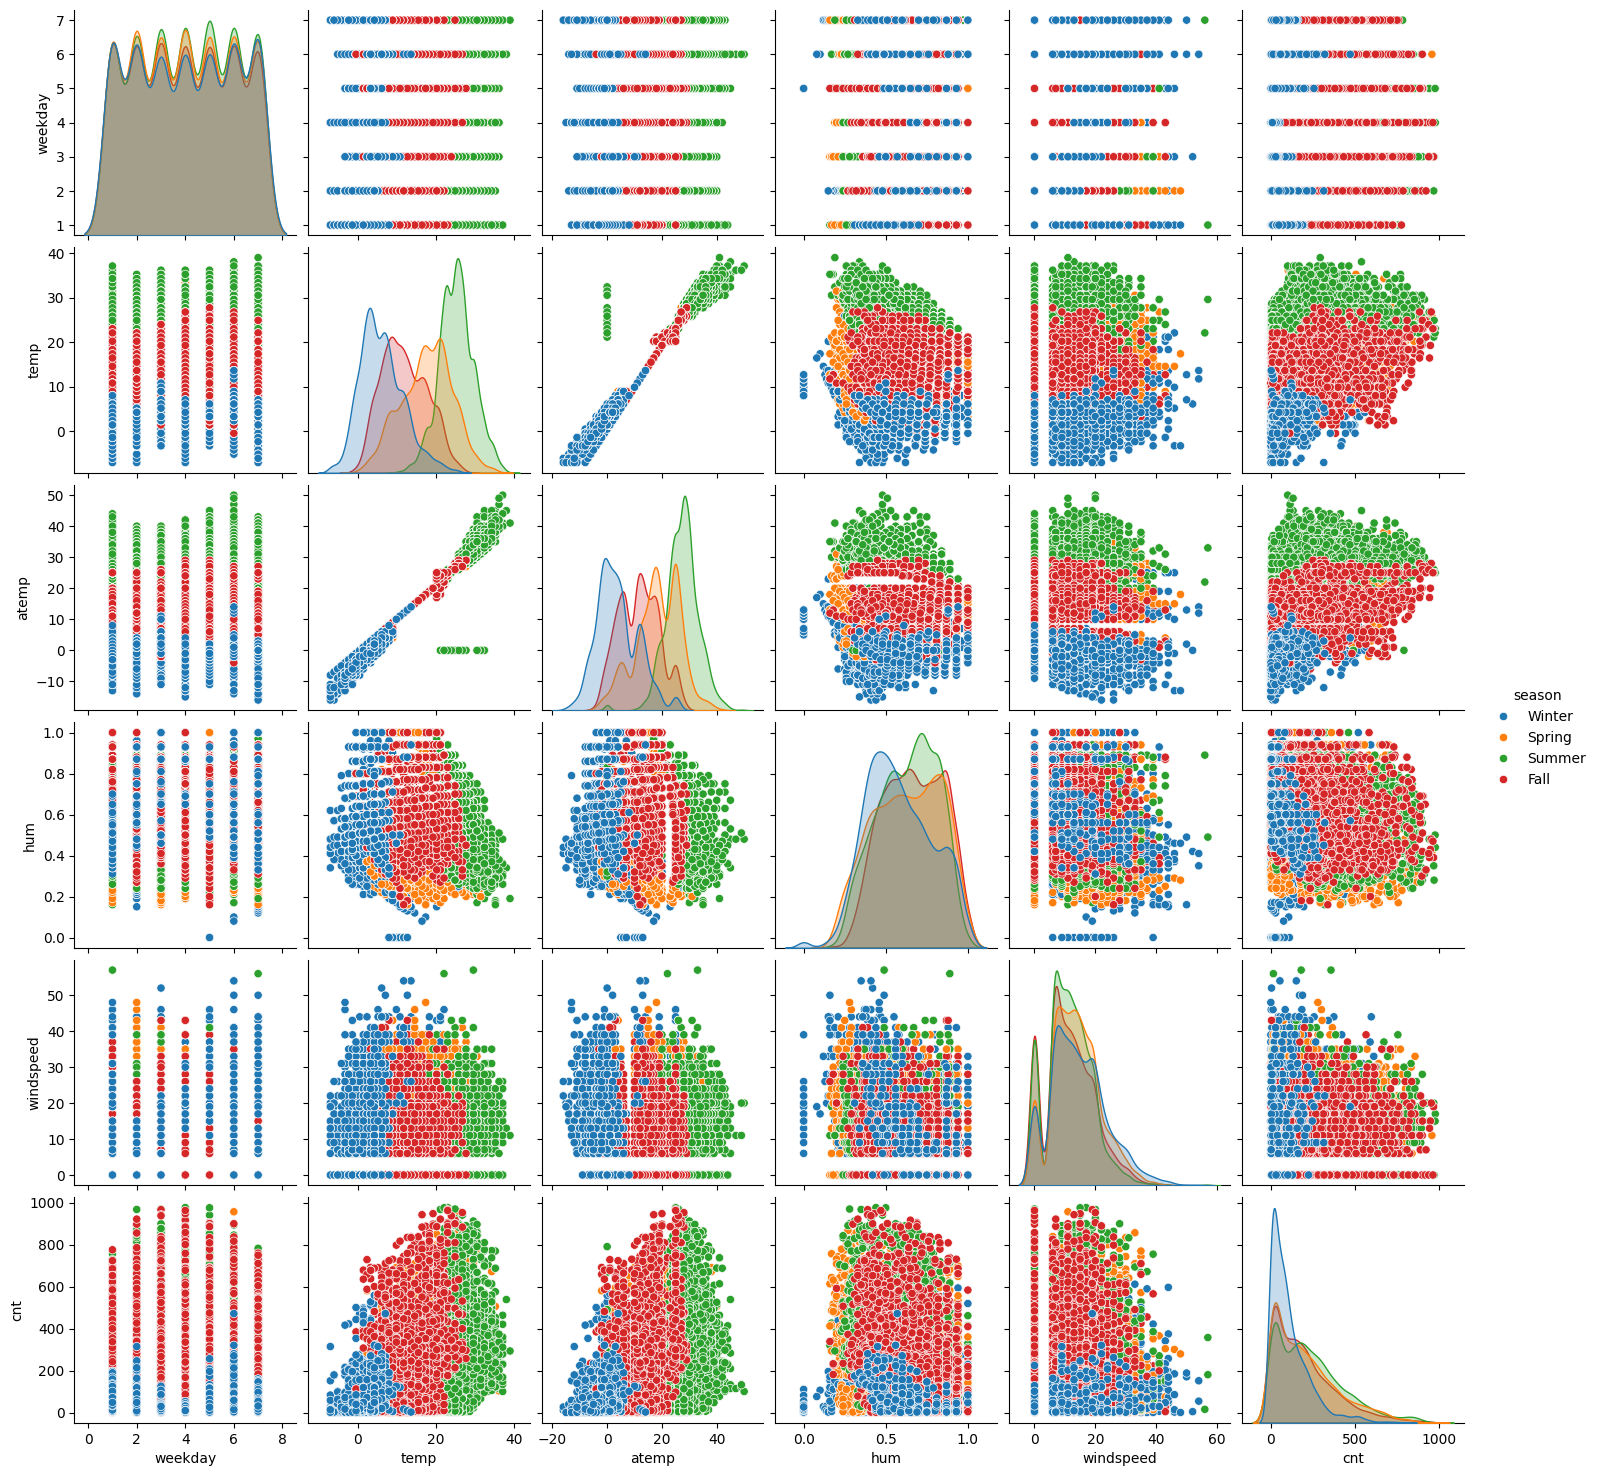

In [38]:
# Paiplot entre todas las variables usando la temporada como criterio de etiquetado
plt.figure(figsize=(10,10))
sns.pairplot(data=df, hue='season', kind='scatter')
plt.show()

A partir de la observación del pairplot anterior, podemos hacernos una perspectiva general de como los posibles pares de variables expresan patrones dentro de los datos. Podemos observar lo siguiente:
* Ningún scatter plot entre variables refleja una relación lineal o de correlación entre sí a escepción de las variables 'temperatura' y 'sensación térmica', lo cuál es natural debido a que éstas dos variables están estrechamente relacionadas y son dependientes entre sí.

* Con base al pairplot cuya variable de etiquetado es la temporada, es posible evidenciar patrones tipo cluster, es decir, éste etiquetado permite descubrir que los datos se agrupan y se evidencian cumulos.
  * A partir de la relación `cnt-temp`, los alquileres de bicicletas que corresponden a los clientes que alquilan durante el invierno constituyen clientes que alquilan de manera menos frecuente. Éstos clientes de baja frecuencia alquilan en temperaturas bajas.

  * A partir de la relación `cnt-temp`, los alquileres de bicicletas que corresponden a los clientes que alquilan durante el otoño constituyen clientes que alquilan con un amplio rango de frecuencia, desde baja hasta alta. Éstos clientes alquilan en temperaturas intermedias.

  * A partir de la relación `cnt-temp`, los alquileres de bicicletas que corresponden a los clientes que alquilan durante el verano constituyen clientes que alquilan con un amplio rango de frecuencia, desde baja hasta alta. Éstos clientes alquilan en temperaturas altas.

  * A partir de la relación `cnt-temp`, los alquileres de bicicletas que corresponden a los clientes que alquilan durante la primavera no exiben un patron visualmente perceptible, aparentemente se encuentran a frecuencias de alquiler y temperaturas altas.

  * De manera general con respecto a la temporada, es posible ver que esta variable estrecha el rango de frecuencia de alquiler de los clientes.

  * A partir de la relación `cnt-windspeed`, no es muy claro el patrón de los datos, sin embargo puede insinuarse que a medida que la temporada cambia, la frecuencia de alquiler de los clientes también cambia, donde el invierno refleja los clientes de baja frecuencia, el otoño aquellos de frecuencia intermedia-alta, mientras que el verano y la primavera parecen reflejar clientes desde baja a alta frecuencia.

* La relación `hum-temp` ilustra que en general, para las temporadas de invierno, otoño y verano, los alquileres ocurren dentro de un rango de humedad que va desde la humedad baja hasta la alta. Por otra parte los clientes que alquilan en primavera suelen hacerlo en un rango de temperatura amplio  pero éstos clientes alquilan en valores de humedad bajos.

<Figure size 1000x1000 with 0 Axes>

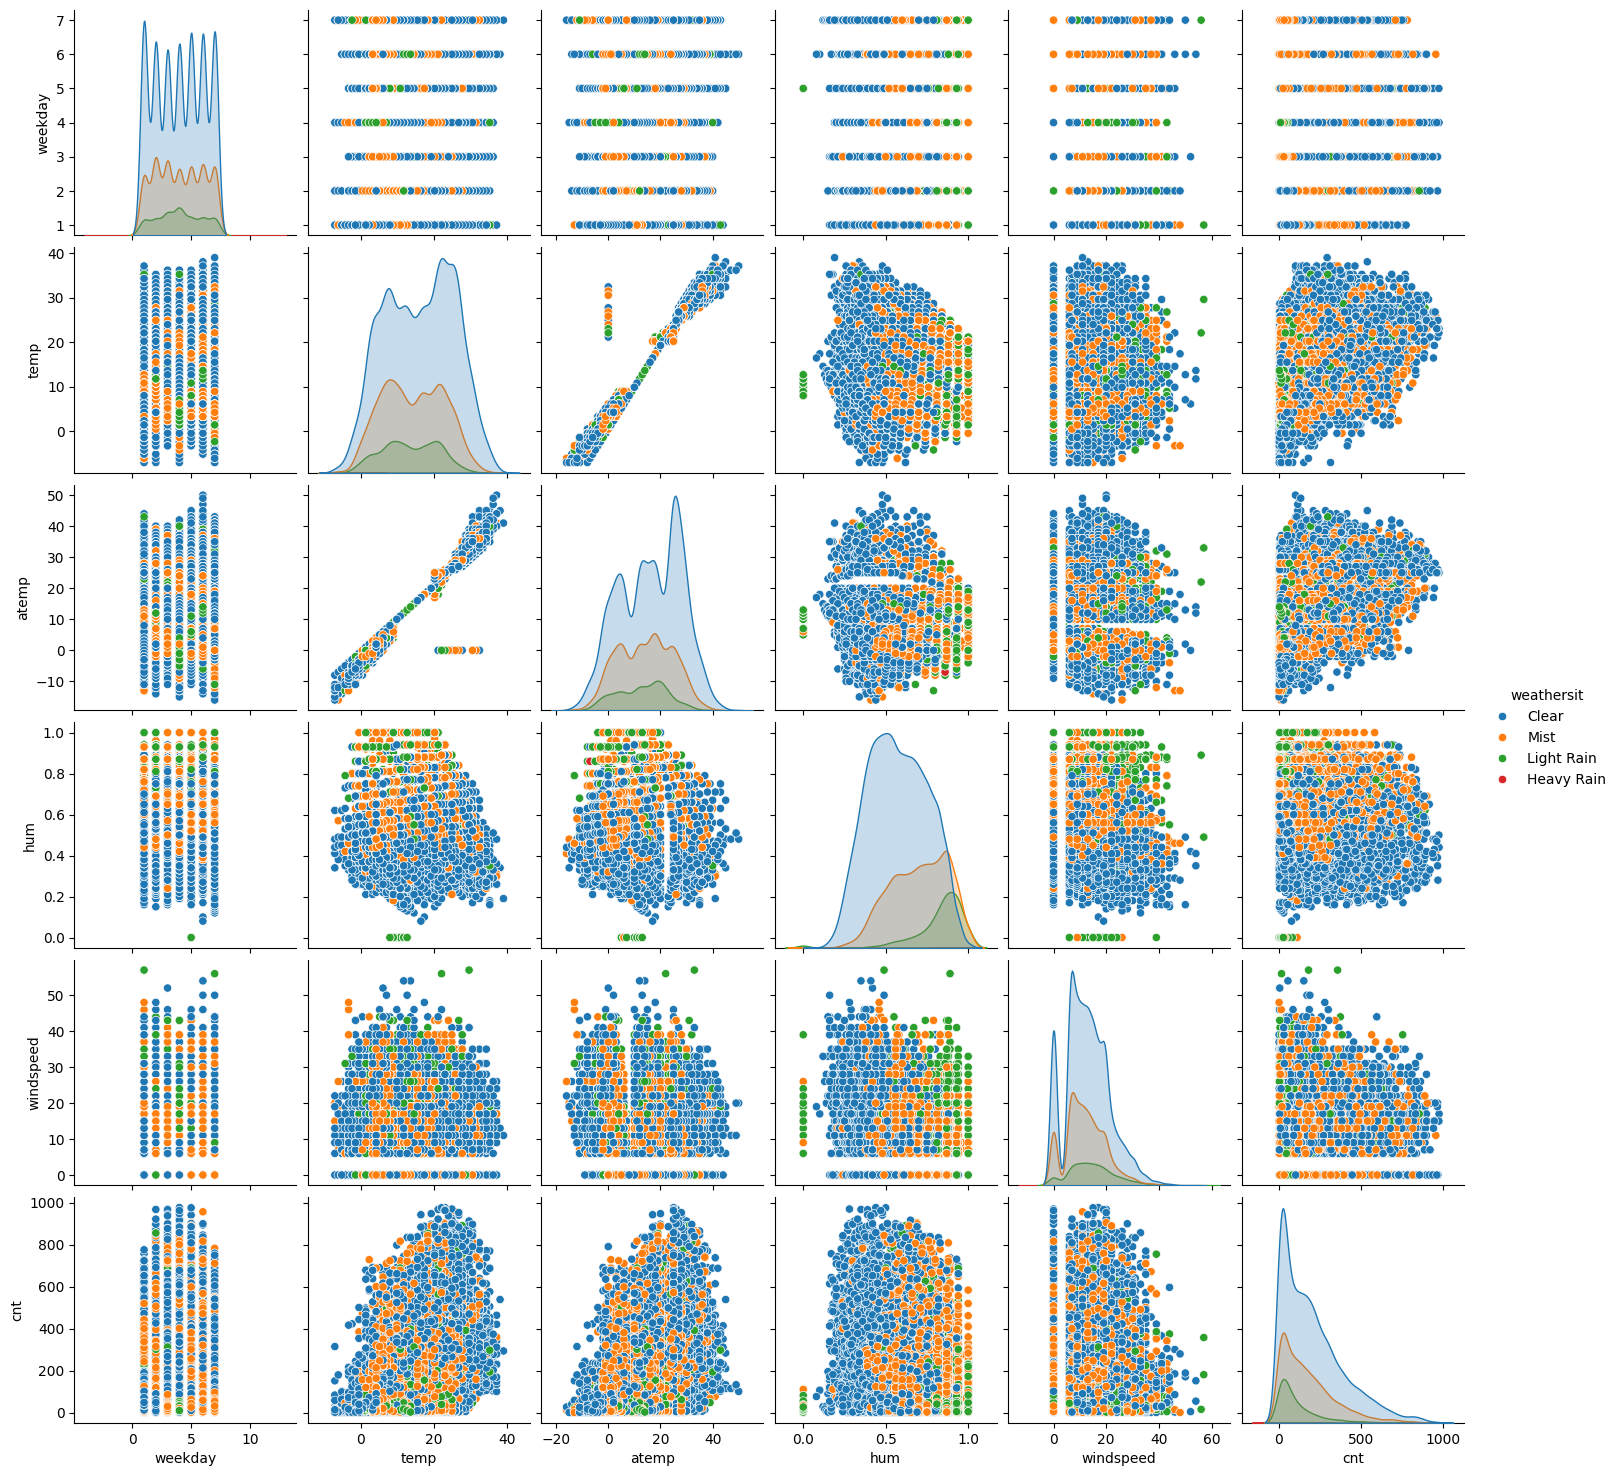

In [39]:
# Paiplot entre todas las variables usando el tipo de clima como criterio de etiquetado
plt.figure(figsize=(10,10))
sns.pairplot(data=df, hue='weathersit', kind='scatter')
plt.show()

A partir del pairplot anterior, es difícil extrar comportamientos o patrones, no obstante la predominancia del color azul deja en evidencia que es en el clima despejado en donde más clientes alquilan bicicletas.

<Figure size 1000x1000 with 0 Axes>

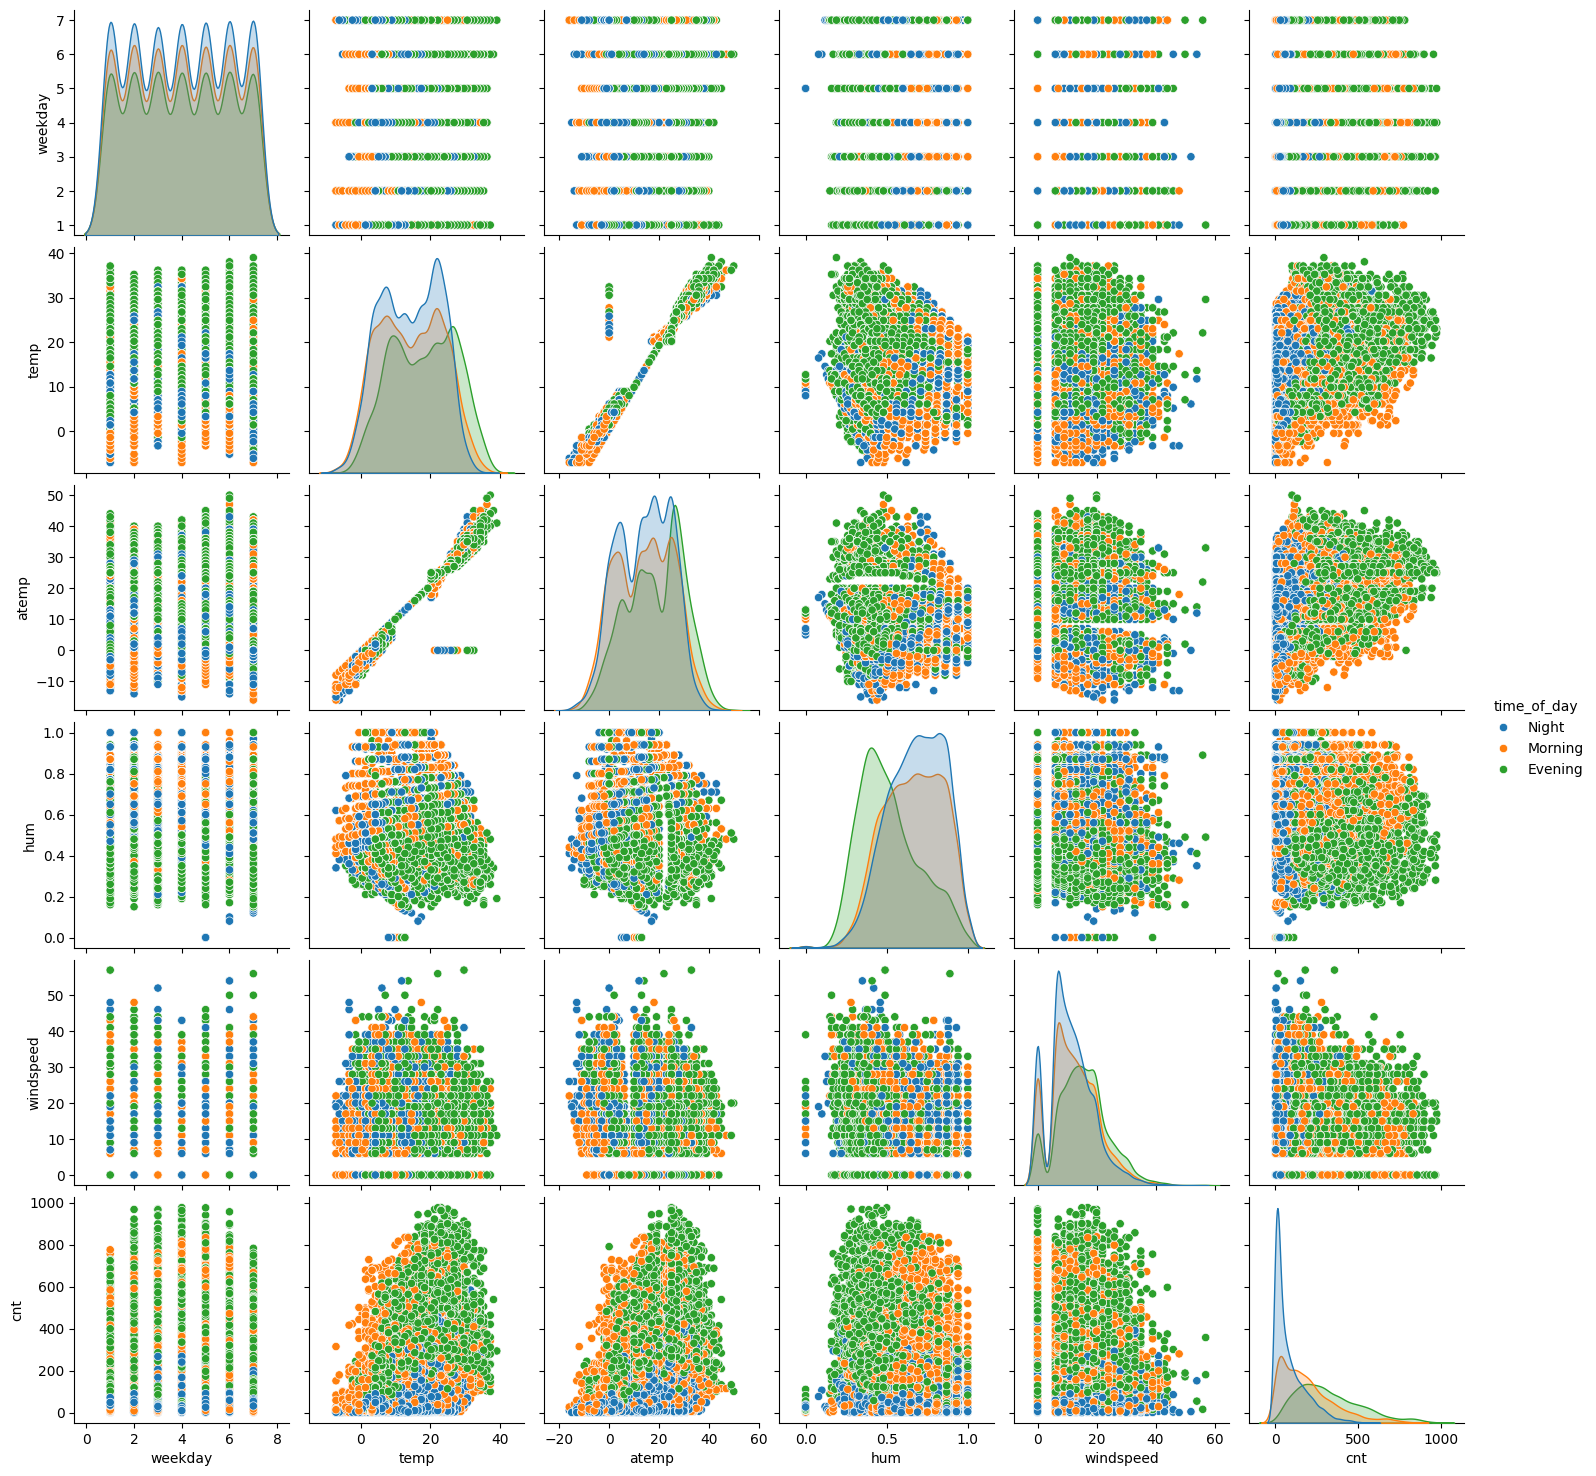

In [40]:
# Paiplot entre todas las variables usando el periodo del dia como criterio de etiquetado
plt.figure(figsize=(10,10))
sns.pairplot(data=df, hue='time_of_day', kind='scatter')
plt.show()

Del anterior pairplot no es posible extraer fácilmente los patrones implicitos en los datos con respecto al tiempo del dia. No obstante puede señalarse lo siguiente:

* A partir de la relación `cnt-temp`, los alquileres de bicicletas que corresponden a los clientes que alquilan durante la tarde constituyen clientes que alquilan con un amplio rango de frecuencia, desde baja hasta alta pero sus alquileres ocurren mayormente entorno a temperaturas medias y altas.

* A partir de la relación `cnt-temp`, los alquileres de bicicletas que corresponden a los clientes que alquilan durante la mañana constituyen clientes que alquilan con un amplio rango de frecuencia, desde baja hasta alta pero sus alquileres ocurren mayormente entorno a temperaturas medias.

* A partir de la relación `cnt-hum`, los alquileres de bicicletas que corresponden a los clientes que alquilan durante la tarde constituyen clientes que alquilan con un amplio rango de frecuencia, desde baja hasta alta pero sus alquileres ocurren mayormente a humedades bajas.

* A partir de la relación `cnt-hum`, los alquileres de bicicletas que corresponden a los clientes que alquilan durante la tarde constituyen clientes que alquilan con un amplio rango de frecuencia, desde baja hasta alta pero sus alquileres ocurren mayormente a humedades altas.

Para evidenciar cuantitativamente la falta de correlación o colinealidad entre las variables, veremos a continuación que las únicas variables que presentan correlación son la temperatura y la sensación térmica de la temperatura. Por otro lado todas las demás variables poseen un coeficiente de correlación prácticamente nulo. No obstante note que las variables de temperatura, sensación térmica y cantidad de  alquiler por cliente (`'cnt'`) tienen una leve correlación, lo cual insinúa una vez más la relación entre los factores del clima y la propension a alquilar bicicletas.

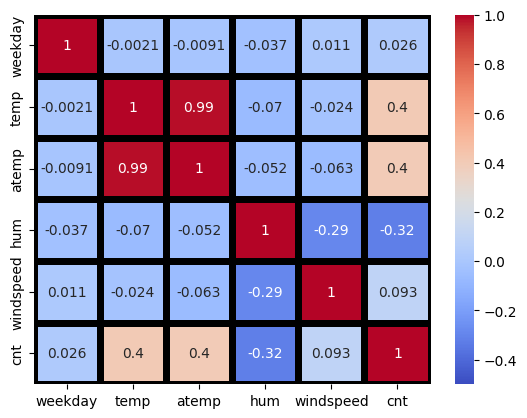

In [60]:
# Correlación entre variables
corr_mat = df.drop(columns=['season', 'weathersit','time_of_day']).corr()
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', linewidths=5,
            linecolor='black', vmin=-0.5, vmax=1,
            cbar=True)
plt.show()

Finalmente, realizaremos un scatter plot que ayude a relacionar múltiples variables relacionadas con el clima tales como la temperatura, la temporada, el tipo de clima y el periodo del dia.

No obstante debido a la complejidad de los datos, solo puede concluirse que se evidencia una predominancia de clientes para el clima despejado, donde entre mayor sensación térmica máyor es la presencia de clientes de alta frecuencia.

<Figure size 800x800 with 0 Axes>

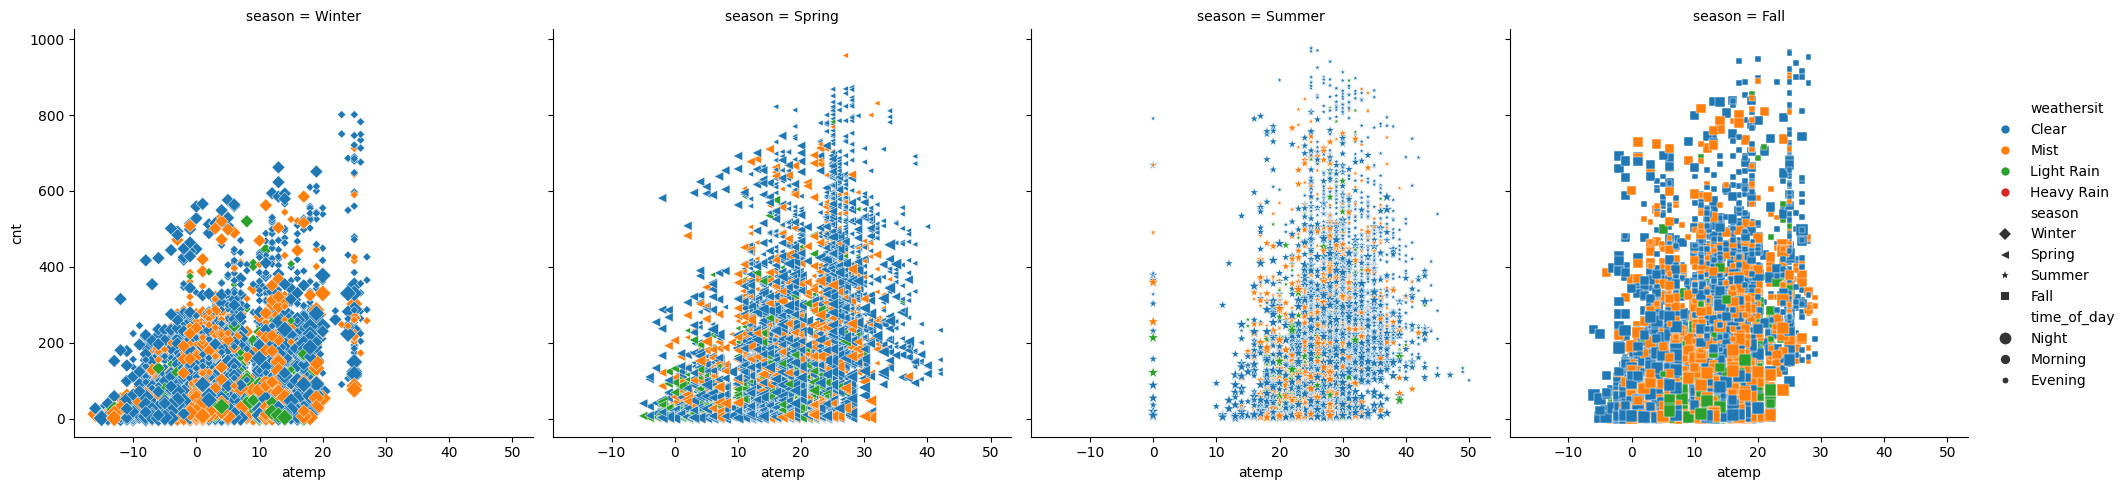

In [42]:
# Relplot para mostrar múltiples divisiones de los datos
plt.figure(figsize=(8,8))
markers = {'Winter':'D','Fall':'s', 'Summer':'*', 'Spring':'<'}
sns.relplot(data=df,x='atemp',y='cnt',
            hue='weathersit',style='season',size='time_of_day',
            markers=markers,
            kind='scatter',col='season')

plt.show()

### 2.5. Análisis multivariado

---
Análisis multivariado

---

Ahora nos preguntamos, ¿Que tendencia exíste entre el número de regístros, el dia de la semana y el tiempo de la semana?. La respuesta a ésta pregúnta es que en cuanto al número de regístros (no al de número de alquileres por persona) se observa  que la noche es aquella que más regístros presenta, seguido de la mañana y la tarde respectivamente para cada día de la semana. No obstante, es importante resaltar que a pesar de que la tarde tenga menos regístros, aquellas personas que rentan en este periodo del día son personas con una alta constancia de alquiler.

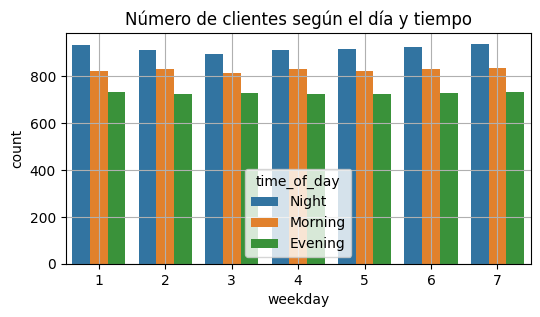

In [43]:
# Cantidad de alquileres con respecto al dia
plt.figure(figsize=(6,3))
sns.countplot(data=df, x='weekday', hue='time_of_day')
plt.title('Número de clientes según el día y tiempo')
plt.grid(True)
plt.show()

¿Que patrón exíste entre el número de regístros (número de personas) de alquiler, el tipo de clima y el periodo del día?. La respuesta a esta semana es que en general, el tipo de clima afecta fuertemente el número de personas que alquilan donde la jerarquía de manera descendente se da de la forma despejado, nuboso, lluvia ligera y lluvia fuerte respectivamente. Por otra parte se observa que cuando el clíma es despejado, la jerarquía con respecto al periodo del dia es en orden descendente noche, mañana y tarde. Para clima nuboso es mañana, noche y tarde. Para lluvia ligera es noche, tarde y mañana. Para finalmente en lluvia fuerte no presentar una jerarquía notable.

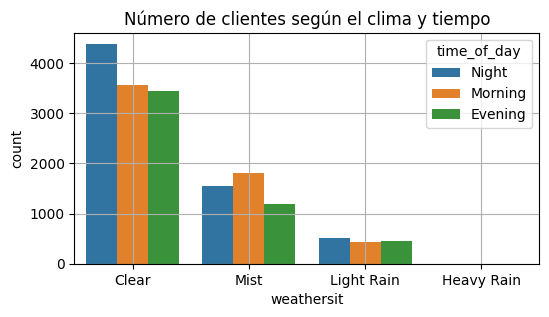

In [44]:
# Cantidad de alquileres con respecto al dia
plt.figure(figsize=(6,3))
sns.countplot(data=df, x='weathersit', hue='time_of_day')
plt.title('Número de clientes según el clima y tiempo')
plt.grid(True)
plt.show()

In [45]:
# Cantidad de regístros por tipo de clima
df['weathersit'].value_counts()

weathersit
Clear         11389
Mist           4535
Light Rain     1410
Heavy Rain        3
Name: count, dtype: int64

Si separamos los datos dependiendo del tipo de clima, se evidencia que este es tal vez el factor más importante en cuanto al alquiler de bicicletas. Al realizar un boxplot para cada periodo o tiempo del día según el tipo de clima, se observa que entre más húmedo-lluvioso sea el clima menor cantidad de clientes desearán alquilar bicicletas, así, las distribuciones de frecuencia de alquiler  por dia de la semana para cada clima nos permite afirmar:

* El clima en donde mayor cantidad alquileres de bicicletas ocurren es en el clima despejado. Es en este clima en donde exíste una mayor variedad de rangos de frecuencia de alquiler por bliente. En general, entre menos ideal sea el clima (menos despejado) más estrechas serán las distribuciones de frecuencia de alquiler.

* El alquiler de bicicletas en dias extremadamente lluviosos es casi nulo.

* Sin importar el tipo de clima, se evidencia en general que los clientes que alquilan en la noche son clientes de baja frecuencia de alquiler, los clientes que alquilan en la mañana son clientes de frecuencias intermedias de alquiler mientras que aquellos clientes que alquilan en la tarde son clientes de alta frecuencia de alquiler.

* A primera vista, el dia de la semana no es un factor tan importante en el alquiler de bicicletas ya que los patrones de los boxplots permanecen prácticamente iguales. No obstante en climas nublados, se evidencia levemente que los días de mayor acumulación de clientes de alta frecuencia de alquiler son los días 1 y 7 de la semana mientras que los dias 3 y 4 son los días de menos acumulación de éste tipo de clientes.

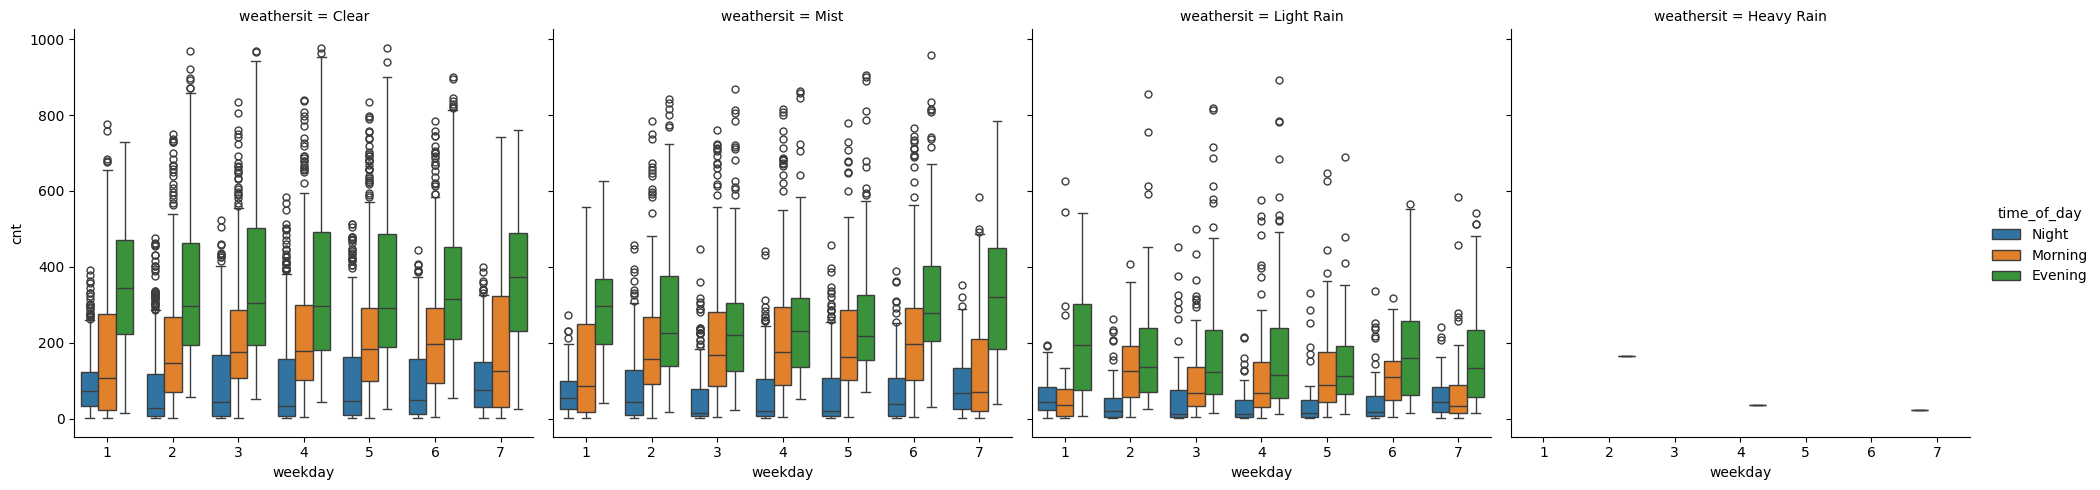

In [46]:
# Catplot comparativo de las variables dia de la semana, tipo de clima y tiempo del dia
sns.catplot(data=df,x='weekday',y='cnt',
            hue='time_of_day',dodge=True,kind='box',
            col='weathersit')
plt.show()

Por otra parte, si ahora separamos los datos de acuerdo a la temporada del año, nos esposible observar lo siguiente:

* Sin importar el dia de la semana ni la temporada, los clientes que alquilan bicicletas en la noche son clientes de baja frecuencia de alquiler, aquellos que alquilan en la mañana son clientes de frecuencias de alquiler intermedias mientras que aquellos clientes que alquilan en la tarde son clientes de alta frecuencia.

* No se evidencia una dependencia fuerte entre la frecuencia de alquiler por cliente y el día de la semana.

* Es en Verano y primavera en donde las distribuciones de frecuencia de alquiler por cliente se hacen más anchas, es decir, los clientes poseen un rango de frecuencia de alquiler más amplio, siendo el verano la temporada en donde los clientes suelen tener una frecuencia de alquiler mayor que en otras temporadas incluso en horarios nocturnos.

* El invierno es la temporada en donde el rango de la frecuencia de alquiler es más estrecho sin importar el horario donde tiene lugar el alquilar. En general las frecuencias de alquiler por cliente para esta temporada las más bajas, seguido del otoño, primavera y luego el verano. Siendo el verano donde los clientes adquieren una mayor frecuencia de alquiler.

* Sin imporatar el día de la semana o la temporada, la noche es el periodo del día donde se regístran clientes con más baja frecuencia de alquiler, seguido por la mañana y la tarde, siendo la tarde el periodo del día en donde más clientes de alta frecuencia se regístran.

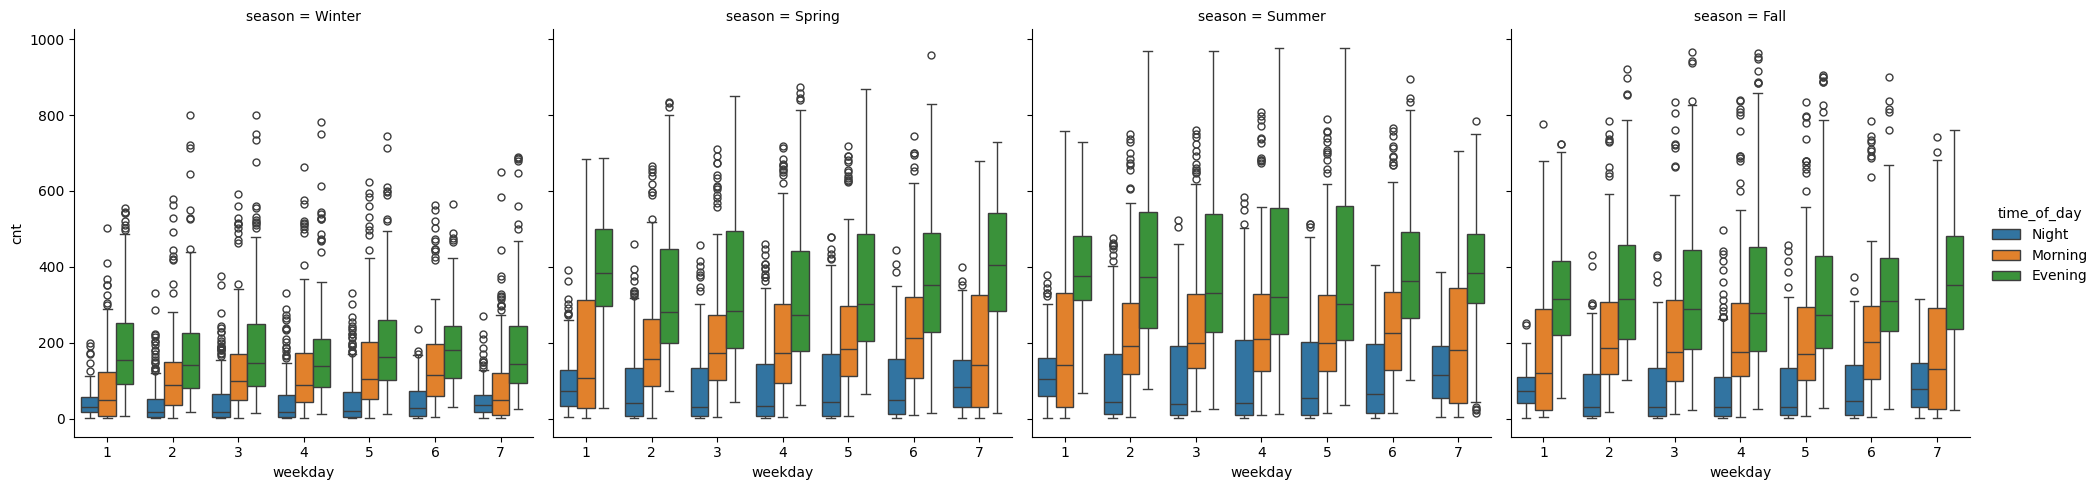

In [47]:
# Catplot comparativo de las variables dia de la semana, tipo de clima y tiempo del dia
sns.catplot(data=df,x='weekday',y='cnt',
            hue='time_of_day',dodge=True,kind='box',
            col='season')
plt.show()

Para concluir nuestro análisis exploratorio de los datos, observemos en detalle cómo las variables relacionadas con el clima y el periodo del día afectan las distribuciones de frecuencia de alquiler por cliente.

Para comenzar, al hacer un gráfico  de la frecuencia de alquiler por cliente según el clima es posible afirmar:

* El tipo de clima tiene un impacto drástico en la cantidad de alquileres y en el tipo de clientes que alquilan bicicletas (en escencia, en la frecuencia de aqluiler de los clientes), de modo tal de que entre más despejado u óptimo sea el clima, se presentan mayor cantidad de clientes (es decir, mayor cantidad de regístros) y mayor frecuencia de alquiler (es decir, mayor cantidad de alquileres por cliente). El efecto del clima es tan determinante, que la suma de todos los alquileres hechos por todos los clientes por cada tipo de clima, resulta ser de tal forma que la cantidad total de alquileres hecha en el clima despejado representa el 70% de todos los alquileres hechos durante el año. Porfavor observe los siguientes dos gráficos los cuales ilustran lo aquí expuesto.

<Figure size 400x300 with 0 Axes>

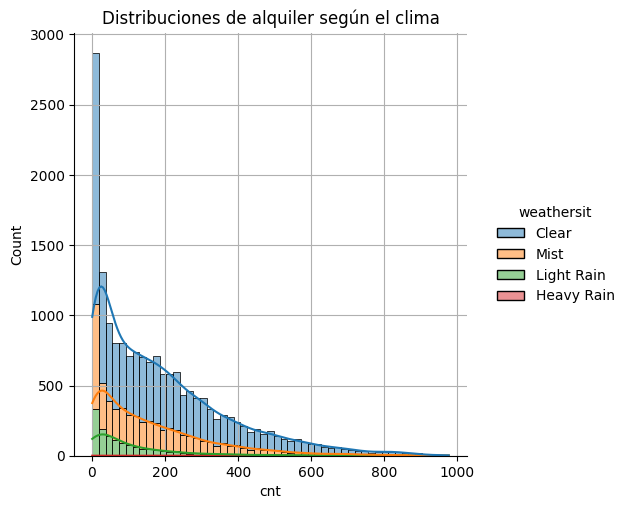

In [48]:
# Crear un histograma con Seaborn y uso del parámetro hue
plt.figure(figsize=(4,3))
sns.displot(data=df,x='cnt',hue='weathersit',
            stat='count',multiple='stack',kde=True)
plt.title('Distribuciones de alquiler según el clima')
plt.grid(True)
plt.show()

In [49]:
# Cantidad de regístros (clientes) por tipo de clima
df['weathersit'].value_counts()

weathersit
Clear         11389
Mist           4535
Light Rain     1410
Heavy Rain        3
Name: count, dtype: int64

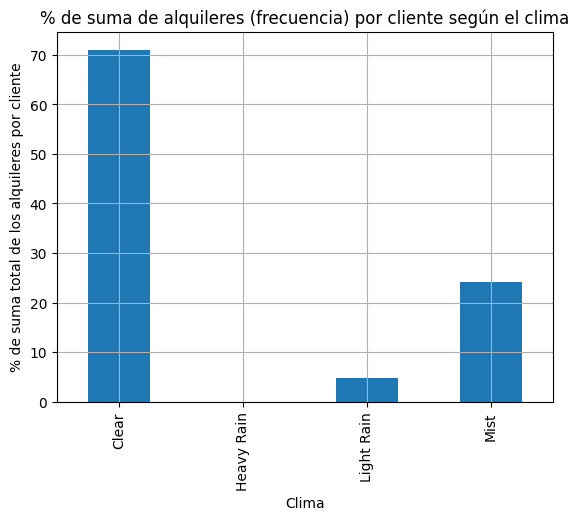

In [50]:
# Suma total de alquileres pro cliente según el clima
grupos_clima = df.groupby('weathersit')['cnt'].sum()
porcentaje_clima =(grupos_clima / grupos_clima.values.sum()) *100
porcentaje_clima.plot(kind='bar')
plt.title('% de suma de alquileres (frecuencia) por cliente según el clima')
plt.grid(True)
plt.xlabel('Clima')
plt.ylabel('% de suma total de los alquileres por cliente')
plt.show()

Por otra parte, si se realiza una distribución tipo histograma de la frecuencia de alquiler (cantidad de alquileres por cliente) para cada temporada, se puede concluir lo siguiente:

* La temporada, al igual que la calidad del clima, es un factor fundamental para el alquiler de bicicletas. Se observa que a medida que la temporada es mas fría, la frecuencia de alquiler (cantidad de alquileres por cliente) disminuye. Note en los siguientes dos gráficos y en el conteo de regístros por temporada, que si bien cada temporada tiene un número de regístros equiparable (todos rondando los 4000), la cantidad de éstos regístros que pertenecen a temporadas más bajas, acumulan sus regístros en las frecuencias de alquiler bajas. Ésto significa que la frecuencia de alquiler es proporcional tanto a la calidad del clima como a la "calidez" de la temporada.

* La razón de que la distribución para la temporada invierno parezca "superior" a la de verano, es que la distribución de verano concentrará más de sus regístros en la cola de la distribución es decir, en los valores de frecuencia de alquiler altas mientras que el invierno concentrará la mayodría de sus regístros en la primera parte de la distribución, es decir, en frecuencias bajas. No obstante, note que según este argumento, el orden de las distribuciónes según su concentración de regístros en frecuencias bajas sería "invierno, otoño, primavera, verano", sin embargo, la distribución más "inferior" resulta ser la distribución de otoño. Se necesita más análisis en este sentido para determinar el por qué la distribución de otoño se encuentra por debajo de todas las demás distribuciones.

* Se evidencia que si sumamos la cantidad de alquileres hechos por todos los clientes en cada temporada (sumamos todas las frecuencias de alquiler), nos damos cuenta de que si organizamos de menor a mayor las temporadas según ésta suma obtenemos el orden "invierno, otoño, primavera, verano". Lo anterior nos indica que efectivamente, la cantidad de alquileres es proporcional a la calidez de la temporada.

<Figure size 400x300 with 0 Axes>

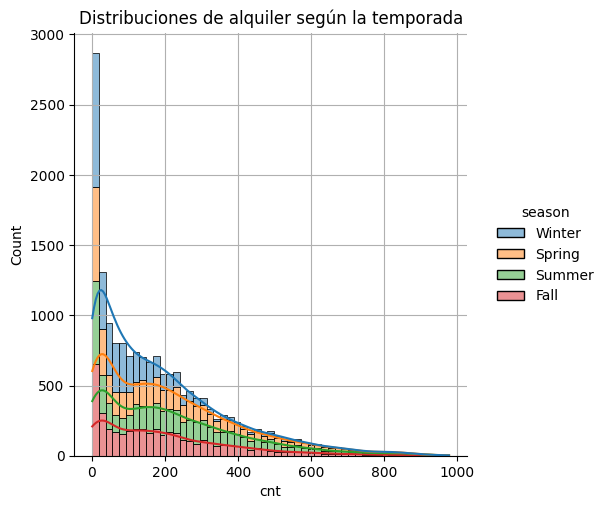

In [51]:
# Frecuencia de alquiler según la temporada
plt.figure(figsize=(4,3))
sns.displot(data=df,x='cnt',hue='season',
            stat='count',multiple='stack',kde=True)
plt.title('Distribuciones de alquiler según la temporada')
plt.grid(True)
plt.show()

In [52]:
# Cantidad de regístros (clientes) por temporada
df['season'].value_counts()

season
Summer    4490
Spring    4400
Winter    4226
Fall      4221
Name: count, dtype: int64

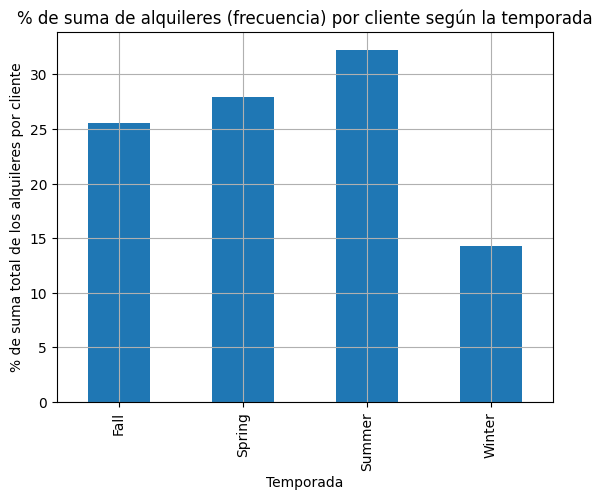

In [53]:
# Suma total de alquileres pro cliente según el clima
grupos_temporada = df.groupby('season')['cnt'].sum()
porcentaje_temporada =(grupos_temporada / grupos_temporada.values.sum()) *100
porcentaje_temporada.plot(kind='bar')
plt.title('% de suma de alquileres (frecuencia) por cliente según la temporada')
plt.grid(True)
plt.xlabel('Temporada')
plt.ylabel('% de suma total de los alquileres por cliente')
plt.show()

Finalmente, si estudiamos la cantidad de regístros y el número total de alquileres por periodo del día, concluimos:

* El periodo del día es importante en la cantidad de alquileres, puede ser tanto por la calidez del día como por cuestiones como la cantidad de movimiento de la ciudad. Se evidencia que entre la jerarquía de las distribuciones corresponde a noche, mañana y tarde. Donde la distribución se ubica más hacia la derecha a medida que lso regístros se acumulan más en la región de frecuencias de alquiler altas, note entonces que ésto evidencia que la tarde es el periodo del día donde más alquileres ocurren y clientes de mayor frecuencia tienen lugar, mientras que la noche es el periodo donde los clientes de baja frecuencia tienen lugar.

* Para complementar lo anterior, observe que la suma de todos los alquileres efectuados por periodo del día es mayor para la tarde, seguido por la mañana y luego por la noche, lo que convierte a la noche en el periodo de menor cantidad de alquileres hechos en la ciudad.

<Figure size 400x300 with 0 Axes>

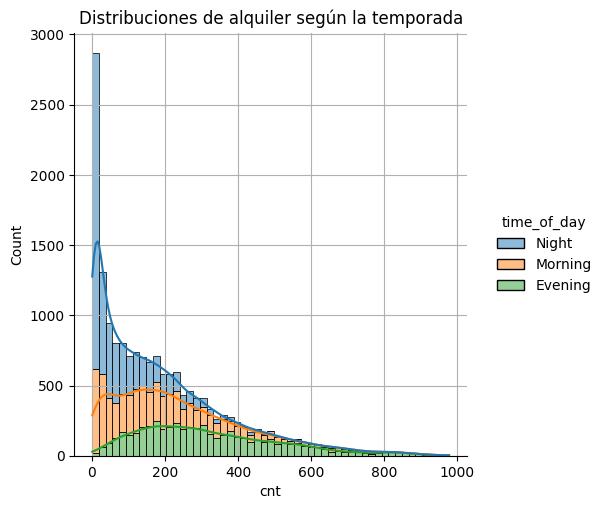

In [54]:
# Crear un histograma con Seaborn y uso del parámetro hue
plt.figure(figsize=(4,3))
sns.displot(data=df,x='cnt',hue='time_of_day',
            stat='count',multiple='stack',kde=True)
plt.title('Distribuciones de alquiler según la temporada')
plt.grid(True)
plt.show()

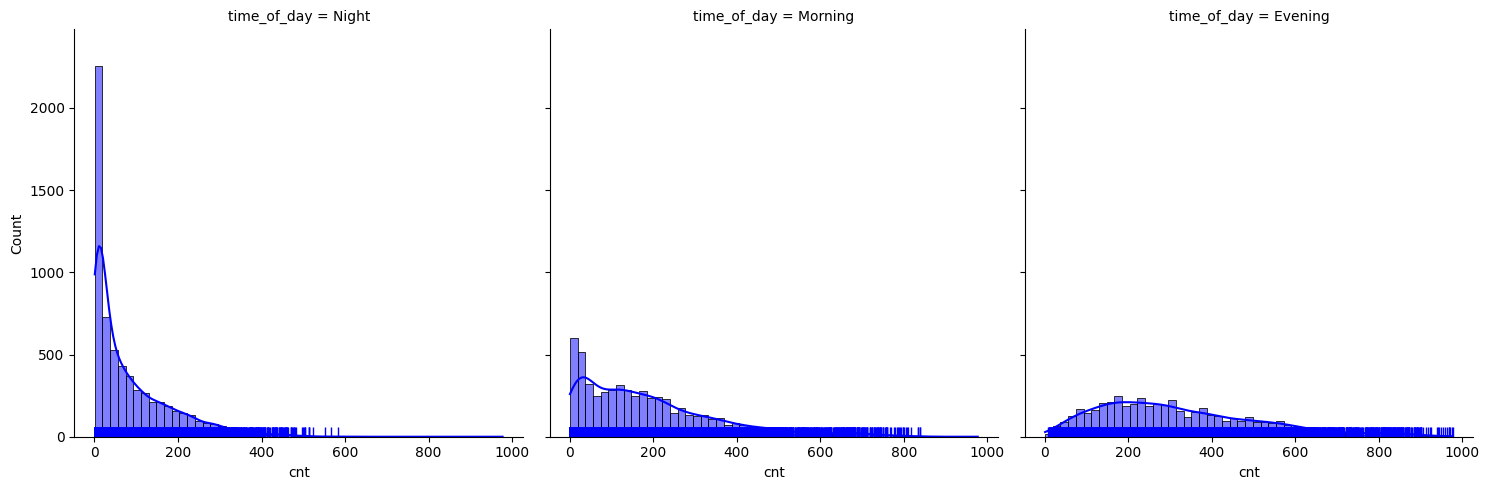

In [55]:
# Crear un displot con facetas por la variable 'furnishing status'
sns.displot(data=df, x='cnt',
            kde=True,
            color='blue', rug=True,
            col='time_of_day')
plt.show()

In [56]:
# Cantidad de regístros por periodo del día
df['time_of_day'].value_counts()

time_of_day
Night      6442
Morning    5797
Evening    5098
Name: count, dtype: int64

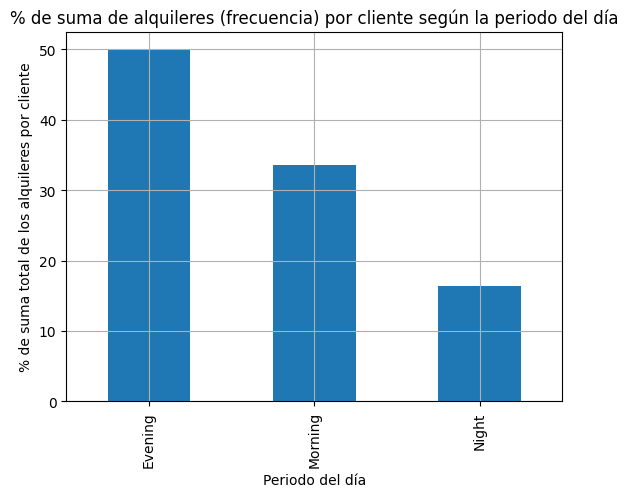

In [57]:
# Suma total de alquileres pro cliente según el clima
grupos_temporada = df.groupby('time_of_day')['cnt'].sum()
porcentaje_temporada =(grupos_temporada / grupos_temporada.values.sum()) *100
porcentaje_temporada.plot(kind='bar')
plt.title('% de suma de alquileres (frecuencia) por cliente según la periodo del día')
plt.grid(True)
plt.xlabel('Periodo del día')
plt.ylabel('% de suma total de los alquileres por cliente')
plt.show()

# **Créditos**
---

**Docente:** Nicolás Castillo Ojeda

**Universidad Pedagógica y Tecnológica de Colombia** - *Diplomado en Data Science - Cohorte I - 2024*


---